In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval
import random as r
import matplotlib.pyplot as plt
from collections import Counter
import tqdm
from sklearn.base import clone

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


In [2]:
# -----------------------------
# 1. Load your datasets
# -----------------------------
print("Loading datasets...")
reviews_df = pd.read_csv("./archive/dataset.csv")  # columns: app_id, app_name, review_text


Loading datasets...


In [3]:
tags_df = pd.read_csv("output.csv")        # columns: APPID, tags

# Convert string representation of dict to actual dict
tags_df['tags'] = tags_df['tags'].apply(lambda x: literal_eval(x))
print(tags_df.head())

# Optional: Keep only tag names (ignore counts)
tags_df['tags'] = tags_df['tags'].apply(lambda d: list(d.keys()) if isinstance(d, dict) else d)

    APPID                                               tags
0      10  {'Action': 5504, 'FPS': 4929, 'Multiplayer': 3...
1    1002  {'2D Fighter': 47, 'Martial Arts': 41, 'Intent...
2  100400       {'Animation & Modeling': 23, 'Software': 11}
3   10090  {'Zombies': 1198, 'World War II': 903, 'FPS': ...
4  100980  {'Animation & Modeling': 38, 'Utilities': 22, ...


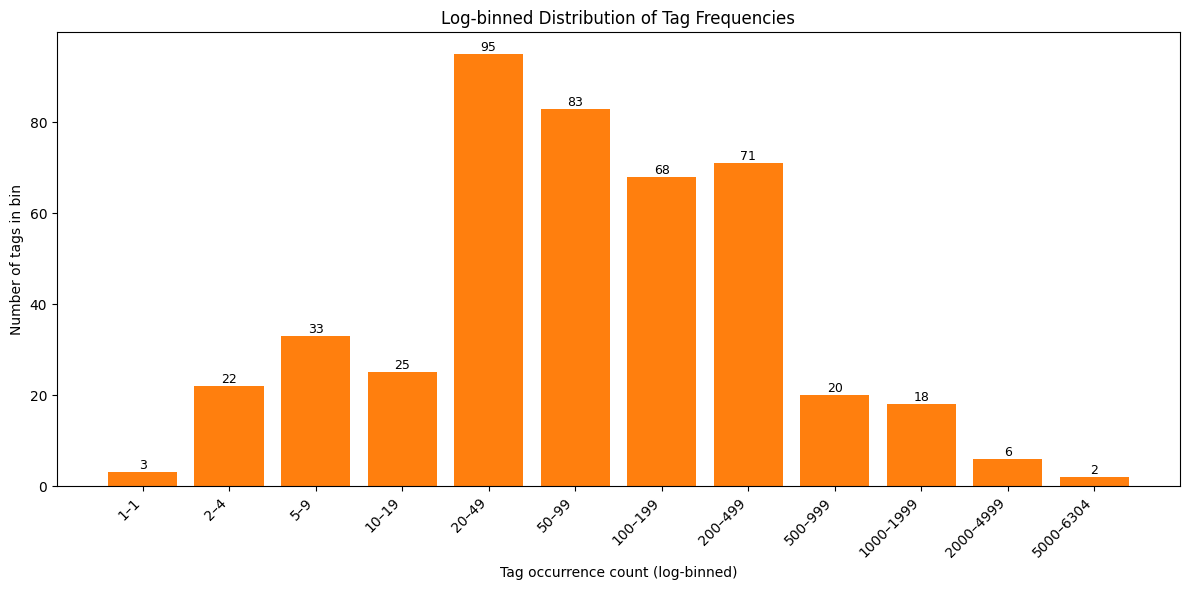

In [4]:

def visualize_tag_distribution(tags_df, bins=20, title="Tag Count Distribution"):
    all_tags = [tag for tags in tags_df['tags'] for tag in tags]
    tag_counts = Counter(all_tags)
    freq_count = Counter(tag_counts.values())

    # Convert frequency-of-frequencies to arrays
    counts = np.array(list(freq_count.keys()))
    num_tags = np.array(list(freq_count.values()))

    # Define logarithmic bins
    bins = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, max(counts)+1]
    for i, b in enumerate(bins):
        if b > max(counts)+1:
            bins[i] = max(counts)+1
            break
        bins = np.unique(np.array(bins)).tolist()

    bin_labels = [f"{bins[i]}–{bins[i+1]-1}" for i in range(len(bins)-1)]

    # Digitize data into bins manually
    binned = np.zeros(len(bins)-1)
    for c, n in freq_count.items():
        idx = np.digitize(c, bins) - 1
        if 0 <= idx < len(binned):  # safety check
            binned[idx] += n

    # Plot
    plt.figure(figsize=(12, 6))
    plt.bar(bin_labels, binned)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Number of tags in bin")
    plt.xlabel("Tag occurrence count (log-binned)")
    plt.title("Log-binned Distribution of Tag Frequencies")
    plt.tight_layout()

    bars = plt.bar(bin_labels, binned)
    # Add exact values on top of each bar
    for bar, value in zip(bars, binned):
        if value > 0:
            plt.text(bar.get_x() + bar.get_width()/2, value, f"{int(value)}",
                    ha='center', va='bottom', fontsize=9)

    plt.show()

visualize_tag_distribution(tags_df)

In [5]:
def filter_rare_tags(tags_df, min_count=1, max_count=7000):
    
    # Flatten all tags into a single list
    all_tags = [tag for tags in tags_df['tags'] for tag in tags]
    tag_counts = Counter(all_tags)
    print("# tags", len(tag_counts))
    # Keep only tags above threshold
    allowed_tags = {tag for tag, count in tag_counts.items() if count >= min_count and count <= max_count}
    print("# allowed tags:",len(allowed_tags))
    # Filter tags per game
    def keep_tags(tag_list):
        return [tag for tag in tag_list if tag in allowed_tags]
    
    tags_df['tags'] = tags_df['tags'].apply(keep_tags)
    
    # Optionally, drop games with no tags left after filtering
    tags_df = tags_df[tags_df['tags'].str.len() > 0].reset_index(drop=True)
    
    return tags_df

# Apply rare tag filtering
tags_df = filter_rare_tags(tags_df, min_count=50)
print("Tags after rare tag filtering:", tags_df.shape)
tags_df.head(2)

# tags 446
# allowed tags: 268
Tags after rare tag filtering: (9950, 2)


,APPID,tags
0,10,"[Action, FPS, Multiplayer, Shooter, Classic, T..."
1,1002,"[2D Fighter, Physics, Indie, Multiplayer, Figh..."


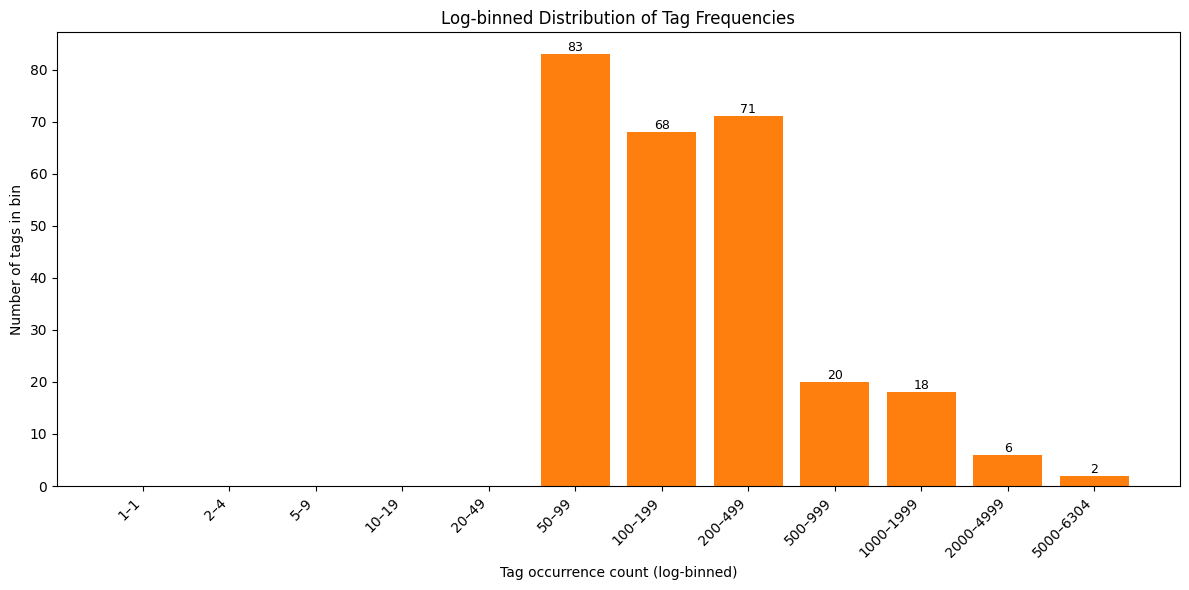

In [6]:
visualize_tag_distribution(tags_df)

In [7]:
# -----------------------------
# 2. Aggregate reviews per game (only games with tags available)
# -----------------------------

print("Aggregating reviews per game...")

reviews_df['app_id'] = reviews_df['app_id'].astype(int)
tags_df['APPID'] = tags_df['APPID'].astype(int)

# Filter reviews to only include games present in tags_df
reviews_with_tags = reviews_df[reviews_df['app_id'].isin(tags_df['APPID'])]

# Convert review_text to string
reviews_with_tags['review_text'] = reviews_with_tags['review_text'].astype(str)

# Filter out reviews shorter than 3 words
reviews_with_tags = reviews_with_tags.loc[reviews_with_tags['review_text'].str.split().str.len() >= 3]

# Aggregate reviews per game and keep app_name
game_reviews = (
    reviews_with_tags.groupby('app_id')
    .agg({
        'review_text': lambda texts: " ".join(texts),
        'app_name': 'first'  # keep the first app_name per app_id
    })
    .reset_index()
)
print("Aggregated reviews shape:", game_reviews.shape)

# Merge with filtered tags
game_reviews = game_reviews.merge(tags_df, left_on='app_id', right_on='APPID')
print("Merged game_reviews shape:", game_reviews.shape)

print("Sample data:")
print(game_reviews.head(2))


Aggregating reviews per game...


C:\Users\joris\AppData\Local\Temp\ipykernel_20784\2601560493.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_with_tags['review_text'] = reviews_with_tags['review_text'].astype(str)


Aggregated reviews shape: (9948, 3)
Merged game_reviews shape: (9948, 5)
Sample data:
   app_id                                        review_text  \
0      10  Ruined my life. This will be more of a ''my ex...   
1      20  When I got this for Christmas in 1999 along wi...   

                app_name  APPID  \
0         Counter-Strike     10   
1  Team Fortress Classic     20   

                                                tags  
0  [Action, FPS, Multiplayer, Shooter, Classic, T...  
1  [Action, FPS, Multiplayer, Classic, Shooter, T...  


In [8]:

game_reviews_sample = game_reviews.head(10).copy()

# Build the vocabulary of unique tags
all_tags = sorted(set(tag.lower() for tag_list in tags_df['tags'] for tag in tag_list))

def getCounts(vocab=all_tags, sents=game_reviews_sample['review_text'].fillna("").tolist()):

    pipe = Pipeline([('count', CountVectorizer(vocabulary=vocab)),

                    ('tfid', TfidfTransformer())], verbose=True).fit(sents)

    tdMatrix = pipe['count'].transform(sents).toarray().transpose()
    return tdMatrix


In [23]:
findTagOccurances = False

if findTagOccurances:
    tdMatrix = getCounts(sents=game_reviews['review_text'].fillna("").tolist())
    print('The shape of the term-document matrix is', tdMatrix.shape)
    tdMatrix_pd = pd.DataFrame(tdMatrix, index=all_tags, columns=list(game_reviews['app_id']))
    tdMatrix_pd.to_csv("TD_Matrix.csv", index=False)

else:
    tdMatrix_pd = pd.read_csv("TD_Matrix.csv")
    tdMatrix_pd.index = all_tags
    tdMatrix_pd.columns = list((game_reviews['app_id']).astype(int))

tdMatrix_pd


,10,20,30,40,50,60,70,80,130,220,...,562320,562600,562700,562710,563140,563180,563400,563430,563510,565340
1980s,0,0,0,0,0,0,0,1,0,2,...,0,0,0,0,0,0,0,0,0,0
1990's,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2.5d,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2d,1,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2d fighter,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
war,6,3,73,4,4,7,14,1,2,27,...,0,0,0,0,0,0,0,0,0,0
wargame,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
western,2,0,0,1,0,1,1,0,1,2,...,0,0,0,2,0,0,0,0,0,0
world war ii,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
def get_top_n_tags(app_id, n=5, td_matrix=tdMatrix_pd):
    """
    Returns a list of top n tags for a given app_id, sorted by count descending.
    """
    if app_id not in td_matrix.columns:
        raise ValueError(f"App ID {app_id} not found in the matrix.")
    
    # Extract the column for this app_id
    col = td_matrix[app_id]
    
    # Create list of (tag, count)
    tag_counts = list(zip(td_matrix.index, col))
    
    # Sort descending by count
    tag_counts.sort(key=lambda x: x[1], reverse=True)
    
    # Keep only tags with count > 0
    tag_counts = [tc for tc in tag_counts if tc[1] > 0]
    
    # Return only top n tags
    return tag_counts[:n]


app_id_example = 10
top_tags = get_top_n_tags(app_id_example, n=5)
print(top_tags)


[('fps', 1117), ('classic', 735), ('shooter', 457), ('multiplayer', 278), ('competitive', 138)]


In [28]:
actual_tags_df = game_reviews[['app_id', 'tags']].rename(columns={'tags': 'actual_tags'})
actual_tags_df['actual_tags'] = actual_tags_df['actual_tags'].apply(lambda tag_list: [t.lower() for t in tag_list])
print(actual_tags_df.shape)
print(actual_tags_df.head())

(9948, 2)
   app_id                                        actual_tags
0      10  [action, fps, multiplayer, shooter, classic, t...
1      20  [action, fps, multiplayer, classic, shooter, t...
2      30  [fps, world war ii, multiplayer, shooter, acti...
3      40  [action, fps, classic, multiplayer, shooter, f...
4      50  [fps, action, classic, sci-fi, singleplayer, s...


In [29]:
def count_actual_tags(app_id):
    return len(actual_tags_df.loc[actual_tags_df['app_id'] == app_id, 'actual_tags'].values[0])

In [30]:
def get_top_tags_df(app_ids=None, n=5, td_matrix=tdMatrix_pd):
    """
    Returns a DataFrame with columns:
    - app_id
    - top_tags: list of top n tags for each app_id
    """
    if app_ids is None:
        app_ids = td_matrix.columns  # all app_ids by default
    
    data = []
    for app_id in app_ids:
        top_tags = get_top_n_tags(app_id, n=268)
        # Keep only the tag names, not counts
        top_tags_only = [tag for tag, count in top_tags]
        data.append({"app_id": app_id, "top_tags": top_tags_only})
    
    return pd.DataFrame(data)

# Just first 10 app_ids for demonstration
top_tags_df = get_top_tags_df(tdMatrix_pd.columns, n=20)
print(top_tags_df.shape)
print(top_tags_df)

(9948, 2)
      app_id                                           top_tags
0         10  [fps, classic, shooter, multiplayer, competiti...
1         20  [classic, fps, multiplayer, shooter, action, c...
2         30  [fps, classic, war, shooter, multiplayer, real...
3         40  [classic, multiplayer, fps, shooter, remake, s...
4         50  [aliens, multiplayer, military, short, fps, ac...
...      ...                                                ...
9943  563180  [platformer, soundtrack, casual, music, classi...
9944  563400          [puzzle, adventure, horror, music, short]
9945  563430  [rpg, combat, music, adventure, puzzle, space,...
9946  563510                                               [vr]
9947  565340                         [zombies, colorful, funny]

[9948 rows x 2 columns]


In [31]:
# Assume your DataFrames
pred_df = top_tags_df        # columns: 'app_id', 'top_tags'
true_df = actual_tags_df     # columns: 'app_id', 'actual_tags'

# Merge on app_id to align
df = pred_df.merge(true_df, on='app_id')

mlb = MultiLabelBinarizer(classes=sorted(all_tags))

# Transform predicted and actual tags into binary indicator matrices
y_pred = mlb.fit_transform(df['top_tags'])
y_true = mlb.fit_transform(df['actual_tags']) 


In [32]:
precision = precision_score(y_true, y_pred, average='micro')  # micro: aggregate TP/FP/FN
recall = recall_score(y_true, y_pred, average='micro')
f1 = f1_score(y_true, y_pred, average='micro')
accuracy = accuracy_score(y_true, y_pred)  # exact match for all tags per row

print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"Accuracy:  {accuracy:.3f}")


Precision: 0.180
Recall:    0.437
F1-score:  0.255
Accuracy:  0.000


In [33]:
def find_top_x(li, x=10, print_output=True):
    flat = np.array([item for sublist in li for item in sublist])

    # Get unique tags and counts
    unique, counts = np.unique(flat, return_counts=True)

    # Sort tags by descending frequency
    sorted_indices = np.argsort(-counts)
    most_common_items = unique[sorted_indices]
    most_common_counts = counts[sorted_indices]

    # Print top 10 tags
    if print_output:
        print("Top tags:")
        for item, count in zip(most_common_items[:x], most_common_counts[:x]):
            print(f"{item}: {count}")
    return most_common_items[:x], most_common_counts[:x]

X=35
top_pred = find_top_x(top_tags_df['top_tags'], x=X, print_output=False)
top_act = find_top_x(actual_tags_df['actual_tags'], x=X, print_output=False)

print(len(top_tags_df['top_tags']), len(actual_tags_df['actual_tags']))
df_compare = pd.DataFrame({
    'pred_Tag': [t for t in top_pred[0]],
    'pred_count': [s for s in top_pred[1]],
    'act_Tag': [t for t in top_act[0]],
    'act_count': [s for s in top_act[1]]
})

music_counts = df_compare.loc[df_compare['act_Tag'] == 'music', 'act_count'].values
total_music = music_counts.sum()  
print(total_music)

for i in actual_tags_df['actual_tags']:
    if i == 'music':
        print(i)

df_compare.head(20)

9948 9948
0


,pred_Tag,pred_count,act_Tag,act_count
0,music,7141,indie,6302
1,short,6689,action,5047
2,difficult,6270,singleplayer,4482
3,action,5401,adventure,4334
4,soundtrack,5013,casual,3420
5,beautiful,4679,strategy,2523
6,funny,4670,simulation,2068
7,classic,4633,multiplayer,2068
8,casual,4609,rpg,1991
9,space,4578,2d,1990


In [34]:
count=0

for i in zip(pred_df['top_tags'], true_df['actual_tags']):
    if len (i[0]) != len(i[1]):
        if len(i[0]) > len(i[1]):
            count+=1

print(count)

7615
